# LLM pretraining



In this notebook, we will explore the process of pretraining a large language model (LLM) from scratch, focusing on a decoder-only transformer architecture.

The vast majority of current LLMs are trained with a causal auto-regressive objective, where the model predicts the next token given the previous tokens.

We will follow this approach to train a character-level LLM on the works of Shakespeare.

In [ ]:
import dataclasses
import math
import random
import torch
import torch.cuda
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torch.utils.data
import time


from typing import Optional

## Part I: The training data

We will start by preparing the data to train the model, available at [https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
](https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
).

This data was originally used in the following [blog post](https://karpathy.github.io/2015/05/21/rnn-effectiveness/), also worth reading.

In [ ]:
# Downloading the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

print("Length in characters: ", len(text))

# let's look at the first 100 characters
print("First 100 characters", "-" * 50)
print(text[:100])

--2025-01-04 09:42:29--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.05s   

2025-01-04 09:42:30 (23.3 MB/s) - ‘input.txt’ saved [1115394/1115394]

Length in characters:  1115394
First 100 characters --------------------------------------------------
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


From here, we can create the model vocabulary, which maps the characters into token ids.

We can train the vocabulary on the whole training set and perform some light testing to check that everything is working as expected.

In [ ]:
class Vocabulary:
  """Character-level vocabulary"""

  def __init__(self, text: str):
    """Initialize the vocabulary, mapping individual characters to integers."""
    # We create two dictionaries, ctoi and itoc: the former mapping characters
    # to unique integers and the latter with the reverse mapping.
    chars = set(text)
    self.ctoi = {c: i for i, c in enumerate(chars)}
    self.itoc = {v: k for k, v in self.ctoi.items()}

  def encode(self, text: str) -> list[int]:
    """Encode a string as a list of token ids."""
    return [self.ctoi[t] for t in text]

  def decode(self, ids: list[int]) -> str:
    """Decode a list of token ids into a string."""
    return "".join(self.itoc[i] for i in ids)

  def __len__(self):
    return len(self.ctoi)

  def __str__(self):
    return f"Vocabulary[size={len(self)}]{self.ctoi}"

vocab = Vocabulary(text)
print(vocab)

# Test if encoding/decoding work
first_chars = text[:1000]
encoded = vocab.encode(first_chars)
decoded = vocab.decode(encoded)
assert first_chars == decoded

Vocabulary[size=65]{'w': 0, '&': 1, 'r': 2, 'Q': 3, '?': 4, 'Z': 5, 'I': 6, 'j': 7, '.': 8, 'N': 9, 'g': 10, 'V': 11, 'k': 12, 'c': 13, 'a': 14, 'd': 15, ',': 16, '$': 17, '!': 18, 'z': 19, 'F': 20, '\n': 21, ';': 22, 'u': 23, 'D': 24, 'e': 25, 'H': 26, 'K': 27, 's': 28, '3': 29, 'm': 30, 'O': 31, 'A': 32, 'U': 33, 'n': 34, 'C': 35, 'B': 36, 'R': 37, 'T': 38, 'q': 39, 'J': 40, 'x': 41, 'G': 42, 'l': 43, 'L': 44, 'b': 45, ':': 46, 'Y': 47, 'i': 48, 'y': 49, 'o': 50, 'P': 51, 'f': 52, 'v': 53, 'X': 54, ' ': 55, 'p': 56, '-': 57, 'E': 58, 'S': 59, 'W': 60, 'h': 61, 'M': 62, "'": 63, 't': 64}


With our vocabulary, we can encode the full text data as a tensor and split it into data for training and validation.

In [ ]:
# Encode all text
encoded_text = torch.tensor(vocab.encode(text))
print("Total tokens:", encoded_text.size(0))
# Split into train and validation
val_size = 2000

encoded_train = encoded_text[:-val_size]
encoded_val = encoded_text[-val_size:]
print("Train tokens:", encoded_train.size(0))
print("Val tokens: ", encoded_val.size(0))

Total tokens: 1115394
Train tokens: 1113394
Val tokens:  2000


From here, we can create the dataset class to iterate the data. Each record will be a chunk of adjacent tokens and the model will learn to predict the next token from the previous ones.

We will train on sequences of 512 tokens, which offers a good trade-off between previous context length and efficiency (due to the quadractic behavior of attention).

In [ ]:
# Predict on block_size contiguous tokens
seq_len = 512


class ShakespeareDataset(torch.utils.data.Dataset):
  """Dataset class return input and target ids for a given idx"""

  def __init__(self, data: torch.Tensor, seq_len: int):
    self.data = data
    self.seq_len = seq_len


  def __getitem__(self, i: int) -> torch.Tensor:
    """Selects the seq_len+1 tokens starting at index i for training.

    Returns:
        (x, y) tuple, with the input and target ids.
    """
    # Account for extra one in LM offset
    data = self.data[i:i + self.seq_len + 1]
    x = data[:-1]
    y = data[1:]
    return x, y

  def __len__(self):
    """The length of the dataset, only considering complete sequences."""
    return len(self.data) - self.seq_len - 1

train = ShakespeareDataset(encoded_train, seq_len)
val = ShakespeareDataset(encoded_val, seq_len)
print("Train size:", len(train), ", val size:", len(val))

Train size: 1112881 , val size: 1487


## Part II: The Transformer Model

In this section of the notebook, we will implement a standard decoder-only transformer model.

There are many flavours of the transformer architecture, varying all components of the transformer network. In this notebook, we will consider the following configuration:

* **Learnt Positional Encoddings** - In conjuntion with sinosoidal embeddings, these are one of the first approaches for encoding positional information in the transformer architecture, by learning position vectors to encode this information. Currently, however, most transformers adopt [RoPE embeddings](https://arxiv.org/abs/2104.09864).

* **Pre layer normalization** - In contrast with the original transformer, we will add layer normalization *before* the attention and mlp blocks, which is shown to improve performance. Nevertheless, we will adopt the original layer normalization instead of the, nowadays more common, [RMS normalization](https://arxiv.org/abs/1910.07467).

* **MLP with gelu activation** - Following the original transformer, we adopt a two layer MLP, but replace the ReLU activation with [GeLU](https://arxiv.org/abs/1606.08415). Recently, larger models also successfuly adopted variations of [GLUs](https://arxiv.org/abs/2002.05202).

We start by defining the model configuration.

In [ ]:
@dataclasses.dataclass
class Config:
  seq_len: int = seq_len
  n_layers: int = 6
  n_heads: int = 6
  hidden_size: int = 384
  # Using the ffn hidden size as 4 times the
  # network hidden size is a standard value.
  ffn_hidden_size: int = 384 * 4
  # Using a head size of hidden_size // n_heads
  # is also a standard approach.
  head_size: int = 384 // 6
  vocab_size: int = len(vocab)
  dropout = 0.3

Afterwards, we will define the self-attention mechanism. In order to make the implementation more efficient, we will:

* Sharing projection matrices across heads;
* Using torch.nn.functional.scaled_dot_product_attention for an efficient implementation of scaled dot-product attention. This implementation is based on [FlashAttention2](https://arxiv.org/abs/2307.08691).

In [ ]:
class MultiHeadAttention(nn.Module):

  def __init__(self, config: Config, /, *, flash: bool = True):
    super().__init__()
    self.config = config
    self.flash = True
    # As is common in most transformer implementations, we will have single projection
    # matrices to compute queries, keys and values for all heads.
    # As such, each projection matrix will map an input of hidden_size to an output
    # of n_heads * head_size.
    self.queries_proj = nn.Linear(config.hidden_size, config.n_heads * config.head_size)
    self.keys_proj = nn.Linear(config.hidden_size, config.n_heads * config.head_size)
    self.values_proj = nn.Linear(config.hidden_size, config.n_heads * config.head_size)
    self.out_proj = nn.Linear(config.n_heads * config.head_size, config.hidden_size)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # x shape: (batch, seq, hidden)
    B, T, _ = x.size()
    n_heads, head_dim = self.config.n_heads, self.config.head_size

    # Compute projections and split by queries, keys and values.
    # q, k, v shapes: (batch, seq, n_heads x head_size).
    q, k, v = self.queries_proj(x), self.keys_proj(x), self.values_proj(x)

    # Isolate heads
    # q, k, v shapes: (batch, n_heads, seq, head_size)
    q = q.view(B, T, n_heads, head_dim).transpose(1, 2)
    k = k.view(B, T, n_heads, head_dim).transpose(1, 2)
    v = v.view(B, T, n_heads, head_dim).transpose(1, 2)

    # Compute scaled dot product attention:
    # Hint 1: Use torch.nn.functional.scaled_dot_product_attention.
    # Hint 2: Be careful to only add dropout during training and ensure a causal mask.
    # out shape: (batch, n_heads, seq, head_size)
    dropout = self.config.dropout if self.training else 0.0
    if self.flash:
      out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout, is_causal=True)
    else:
      scores = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
      causal_mask = torch.tril(torch.ones(T, T))
      causal_mask = causal_mask.view(1, 1, T, T)
      scores = scores.masked_fill(causal_mask == 0, float("-inf"))
      attn = F.softmax(scores, dim=-1)
      attn = F.dropout(attn, p=dropout)
      out = attn @ v

    # Reorder to have all head values for token together
    # out shape: (batch, seq, n_heads * head_size)
    out = out.transpose(1, 2).contiguous().view(B, T, -1)

    # Compute the final projection
    # out shape: (batch, seq, hidden_size)
    out = self.out_proj(out)
    return out

Second, we will define the MLP layer of the transformer. In our implementation, we will adopt:
* Up projection layer mapping hidden_size to ffn_hidden_size;
* Activation function (GeLU);
* Down projection layer mapping ffn_hidden_size to hidden_size;
* Dropout.

In [ ]:
class MLP(nn.Module):

  def __init__(self, config: Config):
    super().__init__()
    self.up_proj = nn.Linear(config.hidden_size, config.ffn_hidden_size)
    self.act = nn.GELU()
    self.down_proj = nn.Linear(config.ffn_hidden_size, config.hidden_size)
    self.dropout = nn.Dropout(config.dropout)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.up_proj(x)
    x = self.act(x)
    x = self.down_proj(x)
    x = self.dropout(x)
    return x

Now, we will define the transformer block. In contrast with the original transformer implementation, we will apply layer normalization before MHA and the MLP.

In [ ]:
class Block(nn.Module):

  def __init__(self, config: Config):
    super().__init__()
    self.attn = MultiHeadAttention(config)
    self.attn_norm = nn.LayerNorm(config.hidden_size)
    self.mlp = MLP(config)
    self.mlp_norm = nn.LayerNorm(config.hidden_size)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    h = self.attn_norm(x)
    h = self.attn(h)
    x = x + h
    h = self.mlp_norm(x)
    h = self.mlp(h)
    x = x + h
    return x

Finally, we will define the transformer decoder, using a causal language modeling objective. For this example, we use learnt embeddings to represent positional information in the transformer.

In [ ]:
class Transformer(nn.Module):

  def __init__(self, config: Config):
    super().__init__()
    # Initialize both embedding layers, one with the size of the vocabulary,
    # and another with the size of the sequence length.
    self.tok_emb = nn.Embedding(config.vocab_size, config.hidden_size)
    self.pos_emb = nn.Embedding(config.seq_len, config.hidden_size)
    # Initialize the transformer blocks
    self.blocks = nn.ModuleList(Block(config) for _ in range(config.n_layers))
    # It is also common to add a final layer norm before the lm_head
    self.final_norm = nn.LayerNorm(config.hidden_size)
    self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

  def forward(
      self,
      inputs: torch.Tensor,
      *,
      labels: Optional[torch.Tensor] = None
  ) -> tuple[torch.Tensor, Optional[torch.Tensor]]:
    """Computes the forward of a transformer model.

    Returns a tuple with two elements. The first is the final logits,
    and the second is the loss (only when labels are provided)
    """
    tok_emb = self.tok_emb(inputs)
    pos_emb = self._get_pos_embeddings(inputs)

    hidden_states = tok_emb + pos_emb

    for block in self.blocks:
      hidden_states = block(hidden_states)

    hidden_states = self.final_norm(hidden_states)
    logits = self.lm_head(hidden_states)

    if labels is None:
      return logits, None

    logits = logits.view(-1, logits.size(-1))
    labels = labels.view(-1)
    loss = F.cross_entropy(logits, labels)
    return logits, loss

  def _get_pos_embeddings(self, tokens: torch.Tensor) -> torch.Tensor:
    """Computes the positional embeddings for the given tokens."""
    batch_size, seq_len = tokens.size()
    pos_idx = torch.arange(seq_len, device=tokens.device)
    pos_emb = self.pos_emb(pos_idx)
    return pos_emb


## Part III: Training and Evaluation

In the final part of this notebook, we will implement the training loop, as well as a generation function, and train our transformer.

In order to mitigate expensive cost of training language models, we will implement [mixed precision training](https://arxiv.org/abs/1710.03740). In this approach, while the weights are stored in fp32, the operations inside the model are performed with fp16, levergaging faster gpu implementations.

In [ ]:
def train_step(
    *,
    model: Transformer,
    optimizer: torch.optim.Optimizer,
    scaler: torch.amp.GradScaler,
    device: str,
    x: torch.Tensor,
    y: torch.Tensor,
):
  optimizer.zero_grad()

  # Runs the model in mixed precision, which improves overall speed
  # with minimal performance degradation.
  # https://pytorch.org/docs/stable/notes/amp_examples.html#typical-mixed-precision-training
  with torch.autocast(device_type=device, dtype=torch.float16):
    _, loss = model(x, labels=y)

  scaler.scale(loss).backward()

  scaler.step(optimizer)

  scaler.update()

  return loss.item()

In [ ]:
@torch.no_grad
def validate(
    *,
    model: Transformer,
    val_dataloader: torch.utils.data.DataLoader,
    device: str,
):
    model.eval()
    total_loss = 0.0
    for x, y in val_dataloader:
        x, y = x.to(device), y.to(device)
        with torch.autocast(device_type=device, dtype=torch.float16):
          _, loss = model(x, labels=y)
        total_loss += loss

    total_loss /= len(val_dataloader)

    model.train()
    return total_loss.item()

In [ ]:
@torch.no_grad
def generate(
  model: nn.Module,
  vocab: Vocabulary,
  input: str,
  new_tokens: int,
  device,
):
  model.eval()
  idx = vocab.encode(input)
  idx = torch.tensor(idx, dtype=torch.long, device=device)
  idx = idx.unsqueeze(0)

  for t in range(new_tokens):
    # The model only considers the previous seq len characters.
    ctx = idx[:, -seq_len:]

    with torch.autocast(device_type=device, dtype=torch.float16):
      logits, _ = model(ctx)

    next_logits = logits[:, -1, :]

    next_probs = torch.softmax(next_logits, dim=-1)

    next_idx = torch.multinomial(next_probs, num_samples=1)
    # append sampled index to the running sequence and continue
    idx = torch.cat((idx, next_idx), dim=1)

  idx = idx.tolist()[0]
  output = vocab.decode(idx)
  model.train()
  return output

In [ ]:
def run_validation(
    *,
    model,
    val_dataloader,
    device,
    val_gen_tokens=100):
  val_input = "\n" # Simulate the end of the last paragraph

  val_loss = validate(
      model=model,
      val_dataloader=val_dataloader,
      device=device,
  )
  print("Validation", "-" * 39)
  print(f"Total loss={val_loss:.3f}")
  test_input = "\n" # Continue to use new line as if beginning a new paragraph
  test_gen_len = 200
  test_output = generate(
      model,
      vocab,
      test_input,
      test_gen_len,
      device
  )
  print(test_output)
  print("-" * 50)
  return val_loss

In [ ]:
def set_seed(seed = 42):
  random.seed(seed)
  torch.manual_seed(seed)
  torch.set_float32_matmul_precision("high")

In [ ]:
def train_model(
    *,
    config = Config(),
    num_steps=2000,
    val_every=500,
    log_every=50):

  set_seed()

  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device == "cpu":
    print("WARNING: Using cpu device, training will be slow")

  train_dataloader = torch.utils.data.DataLoader(
      train, batch_size=64, shuffle=True, pin_memory=True, num_workers=2, prefetch_factor=2,
  )
  val_dataloader = torch.utils.data.DataLoader(
      val, batch_size=64, shuffle=False, pin_memory=True, num_workers=2, prefetch_factor=2,
  )

  model = Transformer(config)

  model_params = sum(p.numel() for p in model.parameters())
  print(f"Total parameters: {model_params / 1e6:.2f}M")

  optimizer = torch.optim.AdamW(
      model.parameters(), lr=1e-3, weight_decay=0.1, betas=(0.9, 0.95), fused=True
  )
  scaler = torch.amp.GradScaler()
  model.to(device)

  dataiter = iter(train_dataloader)
  start_time = time.time()
  start_step = time.time()

  train_losses = []
  val_losses = []

  val_losses.append(run_validation(
      model=model,
      val_dataloader=val_dataloader,
      device=device,
  ))

  for step in range(1, num_steps + 1):
    x, y = next(dataiter)
    x, y = x.to(device), y.to(device)
    token_count = x.numel()
    loss = train_step(
        model=model,
        optimizer=optimizer,
        scaler=scaler,
        device=device,
        x=x,
        y=y)

    train_losses.append(loss)

    step_time = time.time() - start_step
    start_step = time.time()
    if step % log_every == 0:
      completed = step / num_steps * 100
      ellapsed = time.time() - start_time
      tok_per_sec = token_count / step_time
      fmt_ellapsed = time.strftime("%H:%M:%S", time.gmtime(ellapsed))
      print(
          f"Step {step}/{num_steps} ({completed:.0f}%): "
          f"TrainTime={fmt_ellapsed}, "
          f"Loss={loss:.3f}, "
          f"StepTime={step_time:.2}s"
      )
    if step % val_every == 0:
      val_losses.append(run_validation(
          model=model,
          val_dataloader=val_dataloader,
          device=device
      ))

  test_input = "\n" # Continue to use new line as if beginning a new paragraph
  test_gen_len = 1000
  test_output = generate(
      model,
      vocab,
      test_input,
      test_gen_len,
      device
  )
  print("Final generation", "-" * 30)
  print(test_output)

  return train_losses, val_losses

In [ ]:
train_losses, val_losses = train_model()

Total parameters: 10.89M
Validation ---------------------------------------
Total loss=4.318

G!NF&HdVmfBJH,yZCfAjrjqZSAIUGGNmqmH ,dyIsXgMAz;ISSFR
 uPB$sjecONMuomXKhYod.e
h
AsQOvPbbmXshcHRkS.Cz
xv$'VI3ulA;YtmGQs$?nFP!fH$d!YyiHX-
J?:Xxq?PUqX,F.wSIoTiKe!bX-x!EYPgxAuVWjF-deYiH!H!YAAhjYOJXSKv$:Yxq
--------------------------------------------------
Step 50/2000 (2%): TrainTime=00:00:16, Loss=2.477, StepTime=0.22s
Step 100/2000 (5%): TrainTime=00:00:27, Loss=2.480, StepTime=0.22s
Step 150/2000 (8%): TrainTime=00:00:38, Loss=2.412, StepTime=0.22s
Step 200/2000 (10%): TrainTime=00:00:49, Loss=2.330, StepTime=0.23s
Step 250/2000 (12%): TrainTime=00:01:01, Loss=2.194, StepTime=0.23s
Step 300/2000 (15%): TrainTime=00:01:13, Loss=2.047, StepTime=0.24s
Step 350/2000 (18%): TrainTime=00:01:25, Loss=1.925, StepTime=0.24s
Step 400/2000 (20%): TrainTime=00:01:36, Loss=1.839, StepTime=0.24s
Step 450/2000 (22%): TrainTime=00:01:48, Loss=1.747, StepTime=0.23s
Step 500/2000 (25%): TrainTime=00:02:00, Loss=

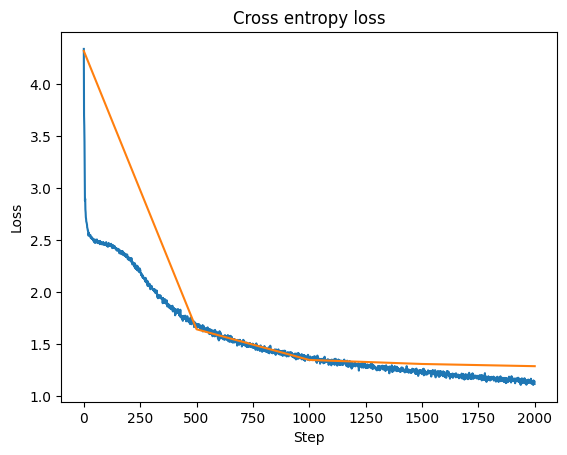

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create x-axis values for training and validation losses
train_steps = list(range(len(train_losses)))
num_val_steps = len(val_losses)
num_steps = len(train_steps)
val_steps = np.linspace(0, num_steps, num_val_steps, dtype=int).tolist()

# Plot Cross Entropy Train losses
plt.plot(train_steps, train_losses, label="Train")
plt.plot(val_steps, val_losses, label="Validation")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Cross entropy loss")
plt.show()